In [1]:
import lzma
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import figure_options
from figure_options import plt, sns, rc_parameters
from scipy.stats import bootstrap
from scipy.special import rel_entr
from environment import run_experiment, RunParameters, RunStatistics
from baifg.model.feedback_graph import FeedbackGraph
from baifg.model.reward_model import GaussianRewardModel, RewardType
from baifg.algorithms.eps_greedy import EpsilonGreedy, EpsilonGreedyParameters
from baifg.algorithms.ucb import UCB
from baifg.algorithms.exp3g import Exp3G, Exp3GParameters
from baifg.algorithms.tas_fg import TaSFG, TaSFGParameters
from baifg.algorithms.base.graph_estimator import GraphEstimator
from baifg.algorithms.base.base_algorithm import BaseAlg
from baifg.utils.graphs import make_loopless_clique, make_loopystar_graph
from baifg.utils.characteristic_time import compute_characteristic_time
from itertools import product
from typing import List, NamedTuple
from tqdm import tqdm

colors = ['#00bfc4', 'mediumorchid', '#7f7f7f','#f8766d', '#3B3B3B','#0096FF','#a3a500']


In [3]:
path = 'full_data_240930.lzma'
# filename = ''


with open(path, 'rb') as f:
    data = pickle.load(f)

df = data['df']

map_name = {
    'Epsilon-greedy': r"$\epsilon$-greedy",
    'Epsilon-greedy IG': r"$\epsilon$-greedy IG",
    'TaSFG': 'TaS-FG',
    'EXP3.G': 'EXP3.G',
    'UCB':'UCB',
}

palette = {
    r"$\epsilon$-greedy": sns.color_palette("Set2")[0],
    r"$\epsilon$-greedy IG": sns.color_palette("Set2")[1],
    'EXP3.G': sns.color_palette("Set2")[2],
    'TaS-FG': sns.color_palette("Set2")[3],
    'UCB': sns.color_palette("Set2")[4],
    'Lower bound': 'black'  # Change to 'darkred' if desired
}

df['algorithm'] = df['algorithm'].apply(lambda x: map_name[x])


In [4]:
df['lb'] = df['characteristic_time'] * (rel_entr(1-df['delta'], df['delta']) + rel_entr(df['delta'], 1-df['delta']))
taSFG_rows = df[df['algorithm'] == 'TaS-FG'].copy()

lb_df = taSFG_rows.copy()

lb_df['algorithm'] = 'Lower bound'
lb_df['stopping_time'] = lb_df['lb']
lb_df['identified_optimal_arm'] = True

df_with_lower_bound = pd.concat([df, lb_df], ignore_index=True)
df_with_lower_bound['delta'] = np.log(1/df_with_lower_bound['delta'])



In [4]:
# Define the grouping columns
group_cols = ['env', 'K', 'algorithm', 'delta']

# Group the DataFrame
grouped = df.groupby(group_cols)

# Define a function to compute mean and confidence intervals
def compute_stats(group, n_boot=1000, ci=95):
    data = group['stopping_time'].astype(float).values  # Convert bool to int (True=1, False=0)
    mean = data.mean()
    res = bootstrap((data,), np.mean)
    return pd.Series({
        'mean_identified_optimal_arm': mean,
        'ci_lower': res.confidence_interval.low,
        'ci_upper': res.confidence_interval.high
    })

# Apply the function to each group
result = grouped.apply(compute_stats).reset_index()
result

/scratch/ipykernel_33427/3062555142.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = grouped.apply(compute_stats).reset_index()


,env,K,algorithm,delta,mean_identified_optimal_arm,ci_lower,ci_upper
0,Loopless clique,5,EXP3.G,0.000912,2820.89,2545.354223,3125.079686
1,Loopless clique,5,EXP3.G,0.003028,2373.78,2102.932353,2677.961998
2,Loopless clique,5,EXP3.G,0.010052,1967.07,1704.114857,2248.959531
3,Loopless clique,5,EXP3.G,0.033373,1440.49,1218.977406,1701.603047
4,Loopless clique,5,EXP3.G,0.110803,1006.38,817.645156,1244.178061
...,...,...,...,...,...,...,...
265,Ring,15,UCB,0.003028,138438.03,122847.878259,153215.138532
266,Ring,15,UCB,0.010052,74747.50,65353.850487,84467.121099
267,Ring,15,UCB,0.033373,36948.43,30968.576425,43420.023206
268,Ring,15,UCB,0.110803,18691.00,14977.612967,23014.245421


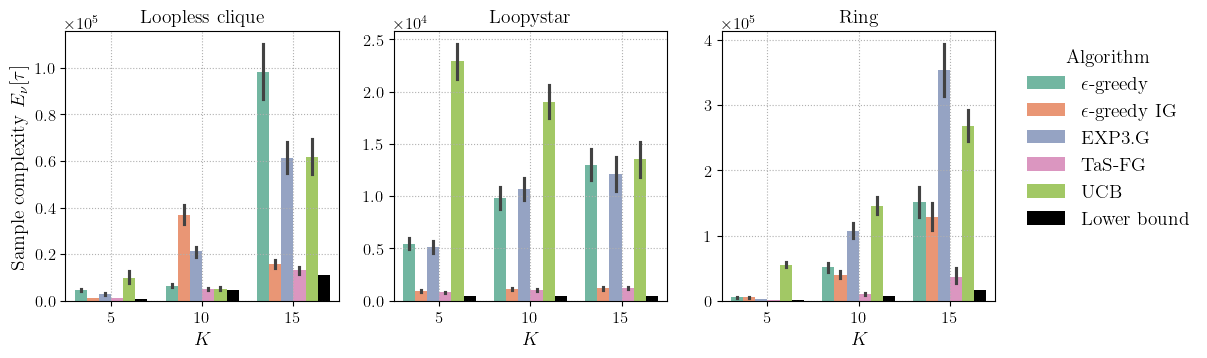

In [6]:
envs = df_with_lower_bound['env'].unique()
num_algo = len(df_with_lower_bound['algorithm'].unique())
# Adding hatch patterns to each algorithm
hatches = {
     r"$\epsilon$-greedy": '/',
    r"$\epsilon$-greedy IG": '\\',
    'EXP3.G': '|',
    'TaS-FG': '-',
    'UCB': '+',
    'Lower bound': 'x'
}
hatches = ['-', '+', '*', r'.', '+', 'o']#, 'o', 'O', '.', '*']

fig, ax = plt.subplots(1,len(envs), figsize=(4 * len(envs),3.5))

for idx, env_name in enumerate(envs):

    # Filter the DataFrame for the selected environment
    
    df_env = df_with_lower_bound[(df_with_lower_bound['env'] == env_name) & (df_with_lower_bound['delta']==7.0)]

    # Create a boxplot
    # sns.boxplot(
    #     x='K',
    #     y='stopping_time',
    #     hue='algorithm',
    #     data=df_env,
    #     palette='Set2',
    #     ax=ax[idx]
    # )
    bar = sns.barplot(
    x='K',
    y='stopping_time',
    hue='algorithm',
    data=df_env,
    palette=palette,
    errorbar=('ci', 95),           # Confidence interval
    #capsize=0.1,      # Width of the error bar caps
    estimator='mean',  # Function to estimate central tendency
    ax=ax[idx],
    legend=True if idx == len(envs)-1 else False
)
    # for i, bars in enumerate(bar.containers):
    #     # Set a different hatch for each group of bars
    #     for p in bars:
    #         p.set_hatch(hatches[i % num_algo == 0])
     # Loop over the bars
    # for i,thisbar in enumerate(bar.patches):
    #     thisbar.set_hatch(hatches[i % num_algo == 0 ])
        # # Set a different hatch for each bar
        # if thisbar.get_label() in hatches.keys():
        #     thisbar.set_hatch(hatches[thisbar.get_label()])
        # thisbar.set_hatch(hatches[i])
    ax[idx].set_ylabel(r'')
    # ax[idx].set_yscale('log')
    ax[idx].set_xlabel('$K$')
    
    ax[idx].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax[idx].set_title(env_name)
    # Adjust legend
    if idx == 0:
        ax[idx].set_ylabel(r'Sample complexity $E_{\nu}[\tau]$')
    if idx == len(envs)-1:
        ax[idx].legend(title='Algorithm', bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)

    ax[idx].grid(linestyle = ":")

    

   

    # # Accessing the patches (bars) in the plot and adding hatches
    # for patch in ax[idx].patches:
    #     algorithm_name = patch.get_label()  # Get the label of the bar (the 'algorithm' name)
        
    #     if algorithm_name in hatches.keys():
    #         print(algorithm_name)
    #         patch.set_hatch(hatches[algorithm_name])
# Show the plot
# plt.tight_layout()
plt.savefig('figures/results/sample_complexity_summary.pdf', bbox_inches='tight')

C:\Users\russo\AppData\Local\Temp\ipykernel_27320\3059852811.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['delta'] = np.log(1/filtered_df['delta']).round(2)
C:\Users\russo\AppData\Local\Temp\ipykernel_27320\3059852811.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['delta'] = np.log(1/filtered_df['delta']).round(2)
C:\Users\russo\AppData\Local\Temp\ipykernel_27320\3059852811.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

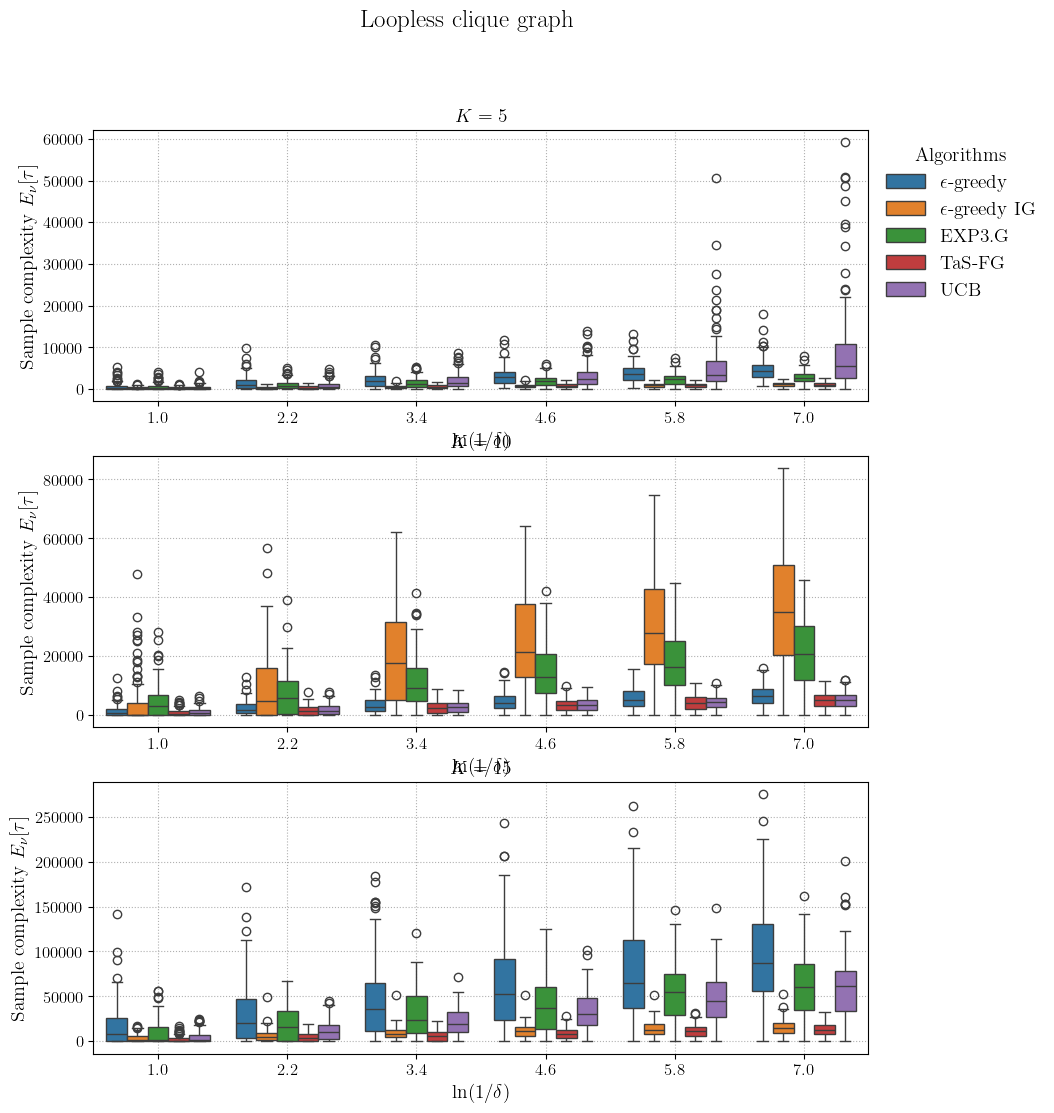

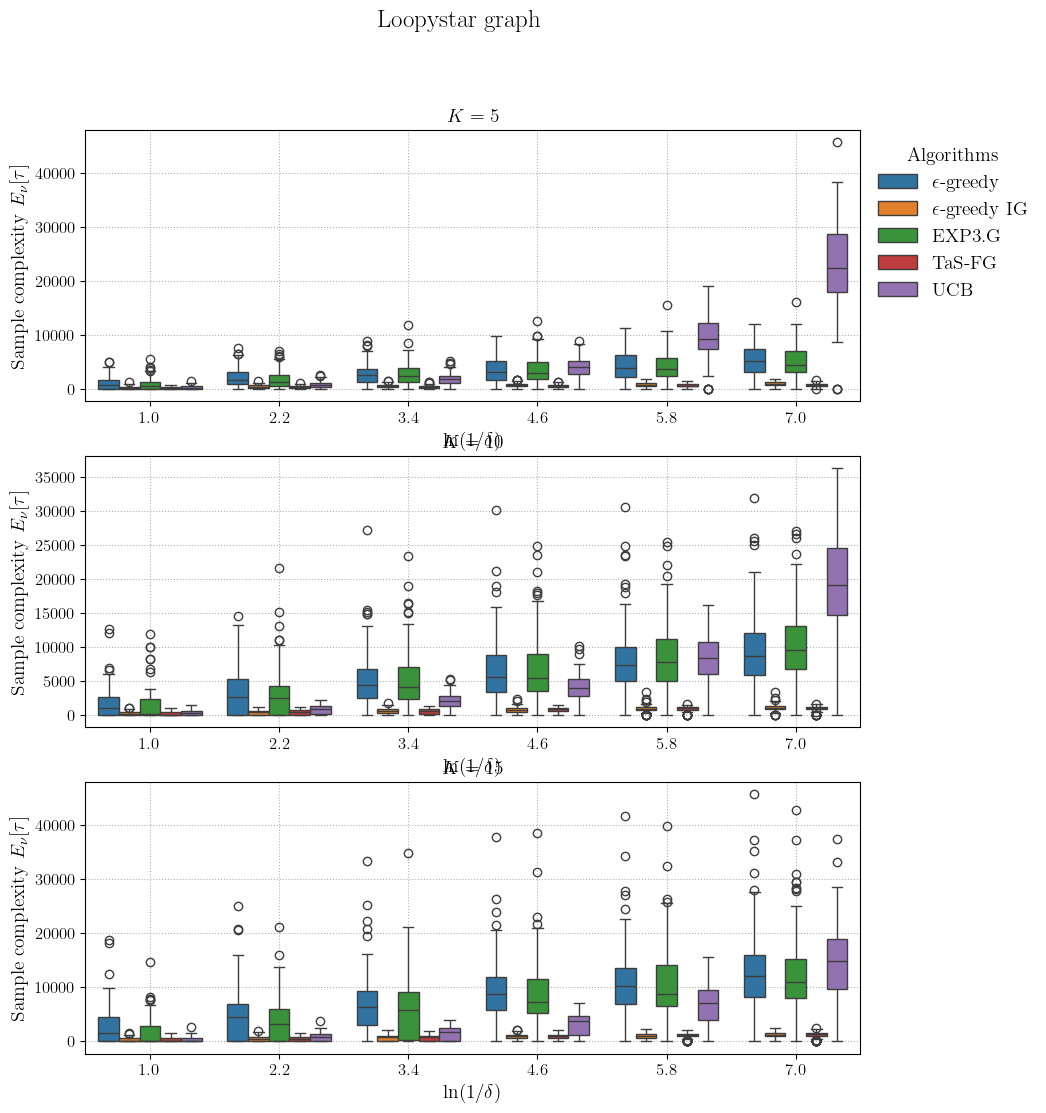

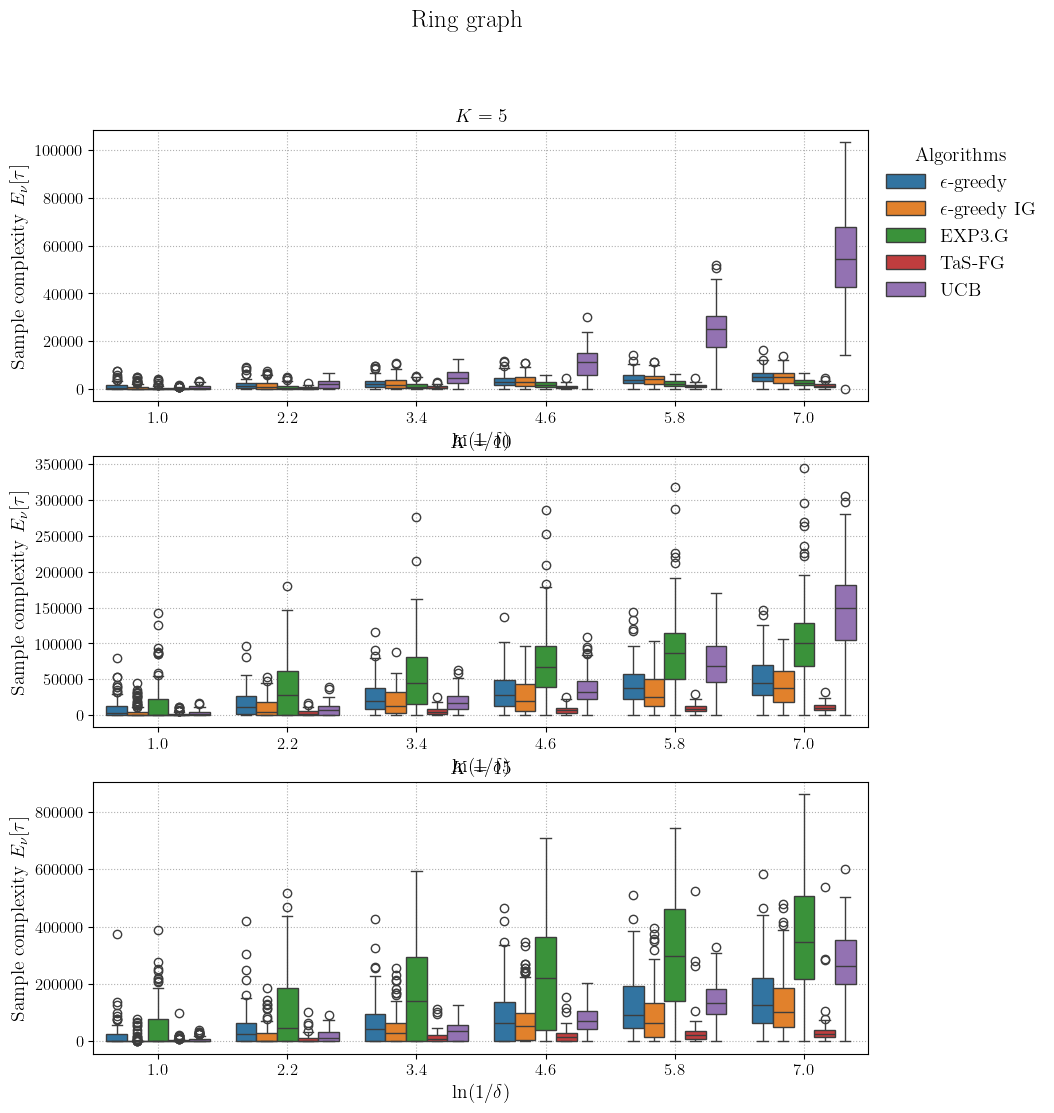

In [9]:
Kvalues = df['K'].unique()
envs = df['env'].unique()

for envname  in envs:
    fig, ax = plt.subplots(len(Kvalues), 1, figsize=(10,12))
    for idx, K in enumerate(Kvalues):
        # Filter the DataFrame for a given environment, e.g., "Loopless clique"
        filtered_df = df[(df['env'] == envname) & (df['K'] == K)]
        filtered_df['delta'] = np.log(1/filtered_df['delta']).round(2)
        sns.boxplot(x='delta', y='stopping_time', hue='algorithm', data=filtered_df, ax=ax[idx], legend=True if idx ==0 else False)

        # Customize labels
        ax[idx].set_xlabel(r'$\ln(1/\delta)$')
        ax[idx].set_ylabel(r'Sample complexity $E_{\nu}[\tau]$')
        ax[idx].set_title(f'$K={K}$')
        ax[idx].grid(linestyle = ":")
    # Display the plot
    ax[0].legend(title='Algorithms', bbox_to_anchor=(1., 1.), ncols=1, frameon=False)
    
    plt.suptitle(f'{envname} graph')
    plt.savefig(f'figures/results/sample_complexity_{envname}.pdf', bbox_inches='tight')